# Introduction
This notebook will handle a denoising autoencoder on the MNIST-dataset.

The specifics of autoencoding are in the fact that there is no label needed to predict as it is known in common deep-learning architecture. Under this particular architecture, the goal is to "predict" its given input values (the features). Therefore we better say "reconstruct" instead of "predict". The model is forced to reconstruct the the given features, this is implemented through three major changes to the traditional NN structure:
1. Building the model out of two seperate models (encoder and decorder).
2. Reducing the given information in the middle of the network (codings).
3. Using the features as label values as well (prediction value is the input).

You will find these structure changes in this notebook

## My other Projects
If you are interested in some more clearly analysis of the dataset, take a look into my other notebooks about the MNIS-dataset:

- cnn-for-digit-recognition-MNIST (accuracy score: 0.99135):
    - https://www.kaggle.com/skiplik/cnn-for-digit-recognition-mnist 
- Finetuning Hyperparameters in Deep Neural Network:
    - https://www.kaggle.com/skiplik/finetuning-hyperparameters-in-deep-neural-network
- Digit Recognition with a Deep Neural Network:
    - https://www.kaggle.com/skiplik/digit-recognition-with-a-deep-neural-network
- Another MNIST Try:
    - https://www.kaggle.com/skiplik/another-mnist-try
- First NN by Detecting Handwritten Characters:
    - https://www.kaggle.com/skiplik/first-nn-by-detecting-handwritten-characters 
- ...

# Imports

In [128]:
import sys
assert sys.version_info >= (3,5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from functools import partial
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

import tensorflow as tf
from tensorflow import keras
from tensorflow import image
from tensorflow import core
from tensorflow.keras import layers

import mlflow
from mlflow import log_metric, log_param, log_artifacts
import mlflow.tensorflow
from mlflow import pyfunc

assert tf.__version__ >= "2.0"

print("Tensorflow Version: ", tf.__version__)
print("Keras Version: ",keras.__version__)

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")


tf.random.set_seed(42)
np.random.seed(42)
random_state=42

kaggle = 0 # Kaggle path active = 1

# change your local path here
if kaggle == 1 :
    MNIST_PATH= '../input/digit-recognizer'
else:
    MNIST_PATH= '../autoencoding-mnist/data/input/digit-recognizer'



import os
for dirname, _, filenames in os.walk(MNIST_PATH): 
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

Tensorflow Version:  2.3.0
Keras Version:  2.4.0
No GPU was detected. LSTMs and CNNs can be very slow without a GPU.
../autoencoding-mnist/data/input/digit-recognizer\keras_reg_160_10_002.sav
../autoencoding-mnist/data/input/digit-recognizer\keras_reg_jl_160_10_002.sav
../autoencoding-mnist/data/input/digit-recognizer\sample_submission.csv
../autoencoding-mnist/data/input/digit-recognizer\test.csv
../autoencoding-mnist/data/input/digit-recognizer\train.csv


## Get The Data

In [129]:
# Data path and file
CSV_FILE_TRAIN='train.csv'
CSV_FILE_TEST='test.csv'

def load_csv_data(path, csv_file):
    csv_path = os.path.join(path, csv_file)
    return pd.read_csv(csv_path)

def load_csv_data_manuel(path, csv_file):
    csv_path = os.path.join(path, csv_file)
    csv_file = open(csv_path, 'r')
    csv_data = csv_file.readlines()
    csv_file.close()
    return csv_data
    

train = load_csv_data(MNIST_PATH,CSV_FILE_TRAIN)
test = load_csv_data(MNIST_PATH,CSV_FILE_TEST)

### Train Val Split

In [130]:
X_train, X_valid, y_train, y_valid =  train_test_split(train.loc[:, train.columns != 'label'], train['label'], test_size=0.33, random_state=random_state)

### Preparing for Neural Network Structure

In [131]:
X_train = X_train.astype(np.float32) / 255
X_valid = X_valid.astype(np.float32) / 255
X_test = test.astype(np.float32) / 255

In [132]:
print(f'"X_train" shape: {X_train.shape}')
print(f'"X_valid" shape: {X_valid.shape}')
print(f'"X_test" shape: {X_test.shape}')

"X_train" shape: (28140, 784)
"X_valid" shape: (13860, 784)
"X_test" shape: (28000, 784)


#### Reshaping Data in Tensor Batch Structure

In [203]:
def reshape_images(df_images):
    df_images_resh = df_images.values.reshape(df_images.shape[0], 28, 28)
    return df_images_resh

def reshape_conv_images(df_images):
    df_images_conv_resh = df_images.values.reshape(df_images.shape[0], 28, 28, 1)
    return df_images_conv_resh

In [201]:
##### TODO: reshape_images() einbauen 
X_train_resh = X_train.values.reshape(X_train.shape[0], 28, 28)
X_valid_resh = X_valid.values.reshape(X_valid.shape[0], 28, 28)

y_train_resh =  y_train.values.reshape(y_train.shape[0], 1)
y_valid_resh = y_valid.values.reshape(y_valid.shape[0], 1)

In [135]:
print(f'"X_train_resh" shape: {X_train_resh.shape}')
print(f'"X_valid_resh" shape: {X_valid_resh.shape}')
print(f'"y_train_resh" shape: {y_train_resh.shape}')
print(f'"y_valid_resh" shape: {y_valid_resh.shape}')

"X_train_resh" shape: (28140, 28, 28)
"X_valid_resh" shape: (13860, 28, 28)
"y_train_resh" shape: (28140, 1)
"y_valid_resh" shape: (13860, 1)


# Plotting 

In [136]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

def show_reconstructions(model, X_valid, n_images=5):
    reconstructions = model.predict(X_valid[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))

    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(X_valid[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

### Plotting One Example Value

In [137]:
print(f'Example label: {y_valid.iloc[1]}')

Example label: 1


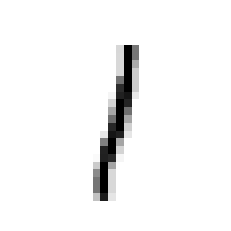

In [138]:
plot_image(X_valid.iloc[1].values.reshape(28,28))

# First Model Creation - Deep Denoising Autoencoder 
An autoencoder architecture includes two seperate models, the encoder and the decorder. In the neuron point of view they both have a rejuvenation which represents a need of information compression - keep only the realy relevant information and drop the less relevant information. The encoder has an input of 784 neurons and an output of only 30 (which represents the codings). On the otherside the decoder has an inputshape of 30 neurons with an layer of 100 neurons, which rises to an layer of 28 * 28 neurons (=784) again. 

These two models combined bring the need of reducing given information and (artificially) recreating them again. Thats the specialty of the autoencoder structure.

### Encoder Architecture

In [139]:
dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")           # Codings
])

In [140]:
dropout_encoder.summary()

Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_10 (Flatten)         (None, 784)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 784)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_38 (Dense)             (None, 30)                3030      
Total params: 81,530
Trainable params: 81,530
Non-trainable params: 0
_________________________________________________________________


#### Decoder Architecture

In [141]:
dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),  ### PROBLEM AREA found: USE THE RIGHT ACTIVATION FUNCTION
    keras.layers.Reshape([28, 28])
])

In [142]:
dropout_decoder.summary()

Model: "sequential_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 100)               3100      
_________________________________________________________________
dense_40 (Dense)             (None, 784)               79184     
_________________________________________________________________
reshape_30 (Reshape)         (None, 28, 28)            0         
Total params: 82,284
Trainable params: 82,284
Non-trainable params: 0
_________________________________________________________________


### Building the Model

In [143]:
dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])
dropout_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.5))

## Training and Logging -  Deep Denoising Autoencoder

### Logging the Model (ML Flow)

In [144]:
#mlflow.tensorflow.autolog()

### Training the Model

In [145]:
history = dropout_ae.fit(X_train_resh, X_train_resh, epochs= 10, validation_data=(X_valid_resh, X_valid_resh))


Epoch 1/10
880/880 [==============================] - 2s 2ms/step - loss: 0.2242 - val_loss: 0.1742
Epoch 2/10
880/880 [==============================] - 2s 2ms/step - loss: 0.1679 - val_loss: 0.1491
Epoch 3/10
880/880 [==============================] - 2s 2ms/step - loss: 0.1543 - val_loss: 0.1407
Epoch 4/10
880/880 [==============================] - 2s 2ms/step - loss: 0.1480 - val_loss: 0.1339
Epoch 5/10
880/880 [==============================] - 2s 2ms/step - loss: 0.1436 - val_loss: 0.1312
Epoch 6/10
880/880 [==============================] - 2s 2ms/step - loss: 0.1406 - val_loss: 0.1311
Epoch 7/10
880/880 [==============================] - 2s 2ms/step - loss: 0.1379 - val_loss: 0.1278
Epoch 8/10
880/880 [==============================] - 2s 2ms/step - loss: 0.1356 - val_loss: 0.1261
Epoch 9/10
880/880 [==============================] - 2s 2ms/step - loss: 0.1337 - val_loss: 0.1223
Epoch 10/10
880/880 [==============================] - 2s 2ms/step - loss: 0.1321 - val_loss: 0.1204

### Losses
The question is: "How good does the model reconstruct the given features/information". So there is no prediction of some label value! The model "predicts" (or better) reconstruct its input values to its best

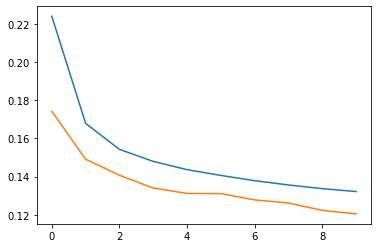

In [146]:
# Getting in touch with the model statistics 
# shows the available keys in models history:  print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

# Second Model Creation - Convolutional Denoising Autoencoder 

### Convolutional Encoder Architecture  

In [295]:
conv_encoder = keras.models.Sequential([
    keras.layers.GaussianNoise(0.1, input_shape = [28, 28, 1]),
    keras.layers.Conv2D(16, kernel_size=3, activation='selu'),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="selu"),
    keras.layers.MaxPool2D(pool_size=4),
    keras.layers.Dense(392, activation="relu")           # Codings
])

In [296]:
conv_encoder.summary()

Model: "sequential_86"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise_11 (GaussianN (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 13, 13, 32)        4640      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 3, 3, 32)          0         
_________________________________________________________________
dense_50 (Dense)             (None, 3, 3, 392)         12936     
Total params: 17,736
Trainable params: 17,736
Non-trainable params: 0
_________________________________________________

### Convolutional Decoder Architecture

In [297]:
conv_decoder = keras.models.Sequential([
    #keras.layers.GaussianNoise(0.1, input_shape=[6, 6, 32] ),
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="valid",activation="selu", input_shape=[3, 3, 392]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="same",activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="same", activation="sigmoid"),
    keras.layers.Reshape([28, 28, 1])
])

In [298]:
conv_decoder.summary()

Model: "sequential_87"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose_126 (Conv2D (None, 7, 7, 32)          112928    
_________________________________________________________________
conv2d_transpose_127 (Conv2D (None, 14, 14, 16)        4624      
_________________________________________________________________
conv2d_transpose_128 (Conv2D (None, 28, 28, 1)         145       
_________________________________________________________________
reshape_37 (Reshape)         (None, 28, 28, 1)         0         
Total params: 117,697
Trainable params: 117,697
Non-trainable params: 0
_________________________________________________________________


### Building the Model - Deep Convolutional Denoising Autoencoder

In [299]:
conv_denoising_ae = keras.models.Sequential([conv_encoder, conv_decoder])
conv_denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.5))

In [300]:
conv_denoising_ae.summary()

Model: "sequential_88"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_86 (Sequential)   (None, 3, 3, 392)         17736     
_________________________________________________________________
sequential_87 (Sequential)   (None, 28, 28, 1)         117697    
Total params: 135,433
Trainable params: 135,433
Non-trainable params: 0
_________________________________________________________________


## Training and Logging - Deep Convolutional Denoising Autoencoder

### Training the Model

In [301]:
X_train_resh_ch = X_train_resh.reshape(X_train_resh.shape[0], 28 ,28 ,1)
X_valid_resh_ch = X_valid_resh.reshape(X_valid_resh.shape[0], 28 ,28 ,1)

In [302]:
history = conv_denoising_ae.fit(X_train_resh_ch, X_train_resh_ch, epochs= 10, validation_data=(X_valid_resh_ch, X_valid_resh_ch))


Epoch 1/10
880/880 [==============================] - 11s 13ms/step - loss: 0.1750 - val_loss: 0.1123
Epoch 2/10
880/880 [==============================] - 11s 12ms/step - loss: 0.1072 - val_loss: 0.1048
Epoch 3/10
880/880 [==============================] - 11s 12ms/step - loss: 0.0977 - val_loss: 0.0947
Epoch 4/10
880/880 [==============================] - 11s 12ms/step - loss: 0.0933 - val_loss: 0.0929
Epoch 5/10
880/880 [==============================] - 11s 12ms/step - loss: 0.0906 - val_loss: 0.0882
Epoch 6/10
880/880 [==============================] - 11s 12ms/step - loss: 0.0887 - val_loss: 0.0882
Epoch 7/10
880/880 [==============================] - 11s 12ms/step - loss: 0.0874 - val_loss: 0.0877
Epoch 8/10
880/880 [==============================] - 11s 12ms/step - loss: 0.0863 - val_loss: 0.0854
Epoch 9/10
880/880 [==============================] - 11s 12ms/step - loss: 0.0855 - val_loss: 0.0848
Epoch 10/10
880/880 [==============================] - 11s 13ms/step - loss: 0.084

# Results - Deep Denoising Autoencoder

## Single Number Test - "6"

### Real Image

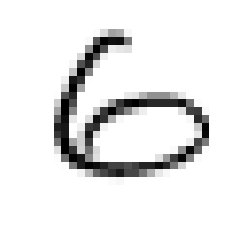

In [303]:
# Test image from a known set
plot_image(X_valid_resh[10])

### ("Predicted") Reconstructed One

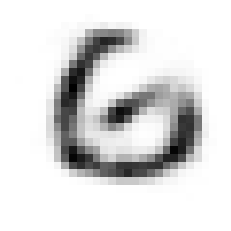

In [304]:
testimage = X_valid_resh[10].reshape(1, 28, 28)     # single image prepared for the test (reshape)
plot_image(dropout_ae.predict(testimage)[0, :, :])  # needed to extract the second and third array of the three dimensional tensor struc for printing the image

### Showing Multi Results

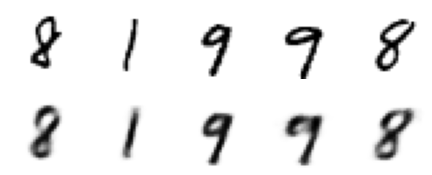

In [305]:
show_reconstructions(dropout_ae, X_valid_resh)

## Using Noised Images

### Creating Noisy Data


In [306]:
new_images = X_test[5:10]
new_images = reshape_images(new_images)
noisy_images = new_images + np.random.randn(5,28,28) *0.1

#### Origin Number


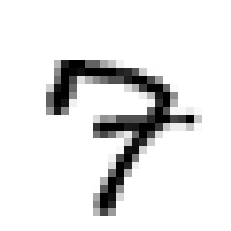

In [307]:
idx_testnumber = 0      # Index of test number for the next plottings 
plot_image(new_images[idx_testnumber])

#### Noisy Number

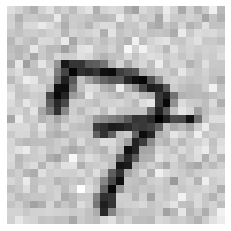

In [308]:
plot_image(noisy_images[idx_testnumber])

In [309]:
noisy_images[4].shape


(28, 28)

#### Denoised Number

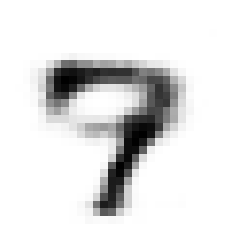

In [310]:
# Very Important ! added a new axis according to the models batch based behavior
plot_image(dropout_ae.predict(noisy_images[np.newaxis ,idx_testnumber]).reshape(28,28)) 

### Multiple Numbers in Comparision 

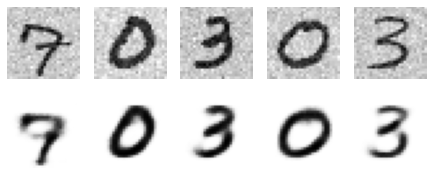

In [311]:
show_reconstructions(dropout_ae, noisy_images)

# Results - Convolutional Denoising Autoencoder

## Using Noised Images

### Creating Noisy Data

In [312]:
new_images_conv = X_test[5:10]
new_images_conv = reshape_conv_images(new_images_conv)
noisy_images_conv = new_images_conv + np.random.randn(5, 28, 28, 1) *0.1

In [313]:
noisy_images_conv.shape

(5, 28, 28, 1)

#### Origin Number


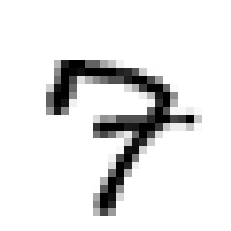

In [314]:
idx_testnumber = 0      # Index of test number for the next plottings 
plot_image(new_images_conv[idx_testnumber])

#### Noisy Number

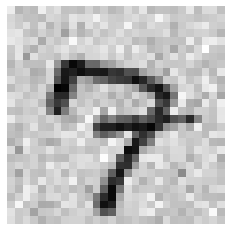

In [315]:
plot_image(noisy_images_conv[idx_testnumber])

#### Denoised Number

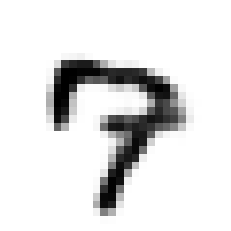

In [316]:
# Very Important ! added a new axis according to the models batch based behavior
plot_image(conv_denoising_ae.predict(noisy_images_conv[np.newaxis ,idx_testnumber]).reshape(28,28))

### Multiple Numbers in Comparision

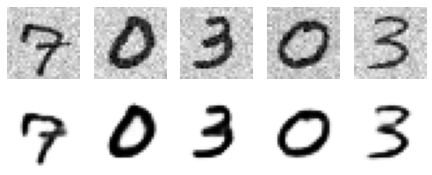

In [317]:
show_reconstructions(conv_denoising_ae, noisy_images_conv)